## Carbon Footprint Assessment:
Develop a metric for evaluating building carbon footprints, accounting for energy and water consumption, size, and other factors.

In [220]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import json

In [208]:
# Load the schema from the JSON file
with open('./data/schema_cleaned2.json') as schema_file:
    schema = json.load(schema_file)

# Convert schema to the format required by pandas
# Note: In this case, we're assuming all the dtypes are compatible with pandas dtypes.
# If there are any discrepancies, you may need to manually adjust the dtypes.
pandas_schema = {key: value for key, value in schema.items()}
feature_list = [key for key, value in schema.items()]

## Data Preparation
Since not all our data is numerical, we'll need to do some one-hot encoding.
Given all the categorical columns, we're going to use pandas library for one-hot encoding.

In [209]:
# Now read the cleaned CSV file using the schema
df_cleaned = pd.read_csv('./data/data_cleaned2.csv', dtype=pandas_schema)

# Select the categorical columns that need one-hot encoding
categorical_columns = [key for key, value in schema.items() if value == 'object']
numerical_columns = [key for key, value in schema.items() if value == 'float64']


## Feature Selection & Scaling
Choosing the relevant features for clustering the different types of buildings

In [210]:
# Select the 'year_built' and 'net_emissions_metric_tons' features
selected_features = df_cleaned[numerical_columns]

# Scale our data for a mean of 0
scaler = StandardScaler()
scaled_data = scaler.fit_transform(selected_features)

In [211]:
# Perform dimensionality reduction using PCA
num_components = 15
pca = PCA(n_components=num_components)  # Adjust the number of components as needed
reduced_features = pca.fit_transform(selected_features)

In [233]:
# Now, you can examine which original features contribute most to the first few components
feature_contributions = abs(pca.components_[num_components - 1])
sorted_features = sorted(zip(selected_features.columns, feature_contributions), key=lambda x: -x[1])

# Print the most important features for the chosen component
custom_feature_names = {}
for feature, contribution in sorted_features:
    if feature == 'multifamily_housing_percent_1':
        custom_feature_names[feature] = 'multifamily_housing_central_heating'
    elif feature == 'multifamily_housing_percent':
        custom_feature_names[feature] = 'multifamily_housing_central_cooling'
    elif feature == 'national_median_source_eui':
        custom_feature_names[feature] = 'national_median_energy_use_intensity'
    else:
        custom_feature_names[feature] = feature


## Most important features for Principal Component 
These feature contribute the most to the variance between the data points. 

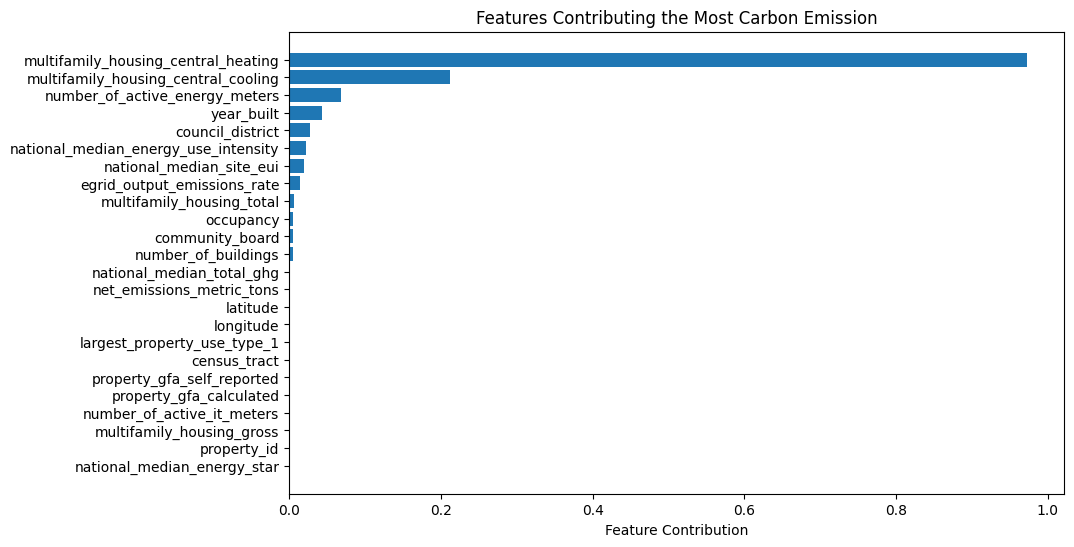

In [239]:
# Update the feature names in the sorted_features dictionary
sorted_features_with_custom_names = [(custom_feature_names.get(feature, feature), contribution) for feature, contribution in sorted_features]

# Extract the feature names and contributions for the plot
feature_names, contributions = zip(*sorted_features_with_custom_names)

# Create a bar plot of feature contributions
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_names)), contributions, align='center')
plt.yticks(range(len(feature_names)), feature_names)
plt.xlabel('Feature Contribution')
plt.title('Features Contributing the Most Carbon Emission')
plt.gca().invert_yaxis()  # Invert the y-axis to display the most important features at the top
plt.show()

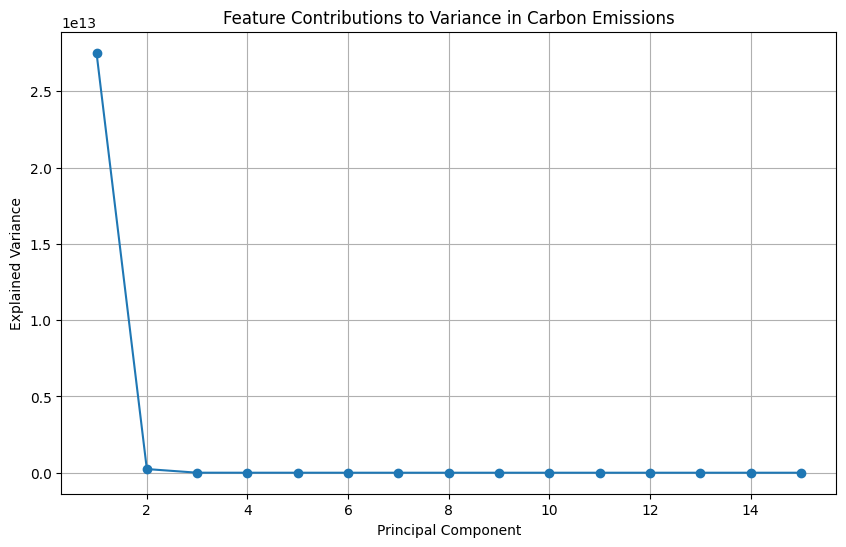

In [241]:
# Fit the PCA model to your data
pca.fit(selected_features)

# Get the transformed data (principal components)
components = pca.transform(selected_features)

# Get the explained variance and eigenvalues
explained_variance = pca.explained_variance_
eigenvalues = pca.singular_values_

# Plot the scree plot
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='-')
plt.title('Feature Contributions to Variance in Carbon Emissions')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.grid(True)
plt.show()

## K-Means Clustering
After dimensionality reduction, we proceed with K-Means clustering on the reduced feature set. The goal is to cluster data points in this lower-dimensional space into K clusters.

/Users/bgutu/Desktop/Fall23/Hackton/DS-Hackathon-Fall-2023/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


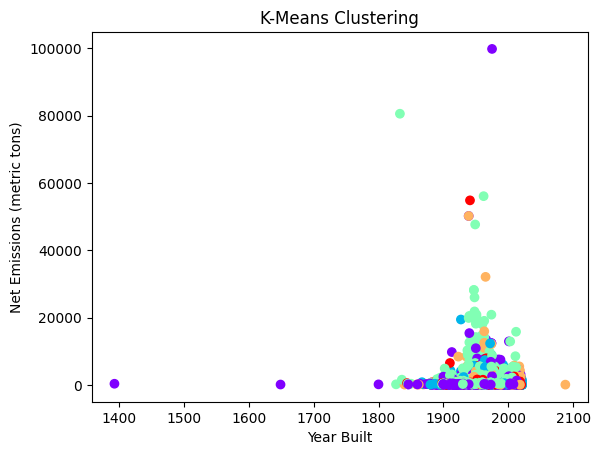

In [243]:
# Choose the number of clusters (K)
K = 5

# Create a K-Means model
kmeans_model = KMeans(n_clusters=K, random_state=42)

# Fit the K-Means model to the selected features
kmeans_model.fit(selected_features)

# Get cluster assignments for each data point in the dataset
cluster_assignments = kmeans_model.predict(selected_features)

# Create a scatter plot to visualize the clusters
plt.scatter(selected_features['year_built'], selected_features['net_emissions_metric_tons'], c=cluster_assignments, cmap='rainbow')
plt.xlabel('Year Built')
plt.ylabel('Net Emissions (metric tons)')
plt.title('K-Means Clustering')
plt.show()
